In [83]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
from scipy.stats import pearsonr

# Finding influential nodes in social networks based on neighbor hood correlation coefficient
Ahmad Zareiea, Amir Sheikhahmadi, Mahdi Jalilic, Mohammad Sajjad Khaksar Fasaei

Link : https://www.sciencedirect.com/science/article/pii/S0950705120300630?via%3Dihub

In [47]:
def neighbors(G, idx):
    return list(dict(G.adjacency())[str(int(idx))])

def len_second_neighbors(idx, neighbor_list=None):
    if neighbor_list is None:
        neighbor_list = neighbors(idx)
    l = []
    for t in neighbor_list:
        l += neighbors(t)
    if str(idx) in l:
        return len(l) - 1
    else:
        return len(l)

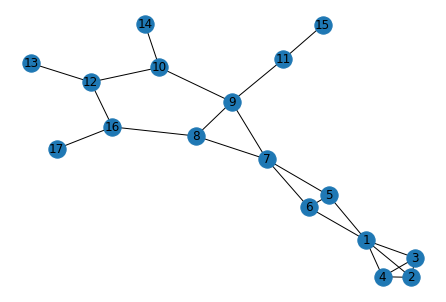

In [117]:
# Figure 1 in Referred Paper
G = nx.Graph()
G.add_edge('1', '2')
G.add_edge('1', '3')
G.add_edge('1', '4')
G.add_edge('1', '5')
G.add_edge('1', '6')
G.add_edge('2', '3')
G.add_edge('2', '4')
G.add_edge('3', '4')
G.add_edge('5', '6')
G.add_edge('5', '7')
G.add_edge('6', '7')
G.add_edge('8', '7')
G.add_edge('9', '7')
G.add_edge('8', '9')
G.add_edge('8', '16')
G.add_edge('9', '10')
G.add_edge('9', '11')
G.add_edge('10', '12')
G.add_edge('10', '14')
G.add_edge('11', '15')
G.add_edge('12', '13')
G.add_edge('12', '16')
G.add_edge('16', '17')
nx.draw(G, with_labels=True)
plt.show()

In [118]:
def assign_it(G):
    subG = copy.deepcopy(G)
    degree = subG.degree()
    it_val = []
    k_it = 1
    it = 1
    while True:
        kshell = nx.algorithms.core.k_shell(G, k_it)
#         print("k-Shell", k_it, "Iteration", it, "Nodes", len(kshell.nodes()))
        while len(kshell):
            it_deg = min(kshell.degree())[1]
#             print(it_deg)
            it_deg_nodes = [n[0] for n in degree if (n[1] == it_deg and kshell.has_node(n[0]))]
#             if len(it_deg_nodes) == 0:
#                 break
            subG.remove_nodes_from(it_deg_nodes)
            kshell.remove_nodes_from(it_deg_nodes)
#             print("IT:", (it, it_deg_nodes))
            if len(it_deg_nodes):
                it_val.append((it, it_deg_nodes))
                it = it + 1
            
            if it_deg == 1:
                it_deg_nodes = list(kshell.nodes())
                it_val.append((it, it_deg_nodes))
#                 print("IT:", (it, it_deg_nodes))
                it = it + 1
                subG.remove_nodes_from(it_deg_nodes)
                break

        if len(kshell) == 0:
            break
        k_it += 1
#     print('\nIT Vectors Obtained')
    return it_val

x = assign_it(G)
for it in x:
    print(it[1])

# Cross Check from Fig1 Referred Paper
# 14, 15, 13, 17
# 11
# 10, 12, 16
# 9, 8
# 7
# 6, 5
# 1, 2, 3, 4

['14', '15', '13', '17']
['11']
['16', '10', '12']
['8', '9']
['7']
['6', '5']
['1', '2', '3', '4']


In [119]:
# ShellVectors
def get_SV(G, it_vec):
    max_iters = len(it_vec) # f
    sv_array = np.zeros((len(G), max_iters))
    for i, v_i in tqdm(enumerate(G.nodes())):
        neigbors_in_G = neighbors(G, v_i)
        for k in range(len(it_vec)):
            for nb in it_vec[k][1]:
                sv_array[i, k] += (nb in neigbors_in_G)
    return sv_array

def get_corr(sv, i, j):
    return pearsonr(sv[int(i) - 1], sv[int(j) - 1])[0]

sv = get_SV(G, x)
print(sv)
print(get_corr(sv, 8, 9))
# SV7 = {0, 0, 0, 2, 0, 2, 0}
# SV8 = {0, 0, 1, 1, 1, 0, 0}
# SV9 = {0, 1, 1, 1, 1, 0, 0}

17it [00:00, 7216.19it/s]

[[0. 0. 0. 0. 0. 2. 3.]
 [0. 0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 2. 0. 2. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 2. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
0.75


In [120]:
def ECMR(G):
    it_vec = assign_it(G)
    sv = get_SV(G, it_vec)
    SCC_array = []
    degree = G.degree()
    max_d = max(degree)[1]
    for v_i in tqdm(G.nodes()):
        SCC = 0
        N_i = neighbors(G, v_i)
        for v_j in N_i:
            CC = get_corr(sv, v_i, v_j)
            SCC = SCC + (2 - CC) + (1 + 2 * len(N_i) / max_d)
        SCC_array.append(SCC)

    CRM_array = []
    for i, v_i in tqdm(enumerate(G.nodes())):
        CRM = 0
        N_i = neighbors(G, v_i)
        for j, v_j in enumerate(N_i):
            CRM += SCC_array[j]
        CRM_array.append(CRM)
    
    ECRM_array = []
    for i, v_i in tqdm(enumerate(G.nodes())):
        ECRM = 0
        N_i = neighbors(G, v_i)
        for j, v_j in enumerate(N_i):
            ECRM += CRM_array[j]
        ECRM_array.append(ECRM)
    return np.argsort(-1 * np.array(ECRM_array)) + 1 # +1 coz Graph nodes start at 1
t = ECMR(G)

17it [00:00, 10698.15it/s]
100%|██████████| 17/17 [00:00<00:00, 4920.85it/s]
17it [00:00, 22571.44it/s]
17it [00:00, 38293.86it/s]


In [121]:
t

array([ 1,  7,  9,  4,  5,  6,  2,  8, 10, 11, 13,  3, 12, 16, 14, 15, 17])